In [1]:
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
import rasterio.features
import rasterio.warp
import glob
import os
import rioxarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio.enums import Resampling
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep
from shapely.geometry import mapping
import subprocess
from osgeo import gdal
import multiprocessing as mp
from typing import List, Any, Sequence, Tuple
import xarray as xarray
from numpy import savetxt
import seaborn as sns



%matplotlib inline


## Correcting Classified Images for pixels where there was cloud cover in one year and not the other

In [14]:
#test
image_1 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2014_corrected_classified.npy')
image_2 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/PIREDD_Plataue_L8_2015_classified.npy')
image_3 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/PIREDD_Plataue_L8_2016_classified.npy')

In [15]:
image_1 = image_1.astype(int)
image_2 = image_2.astype(int)
image_3 = image_3.astype(int)

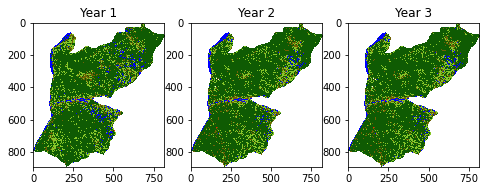

In [16]:
#visualise boths landcover maps

# See https://github.com/matplotlib/matplotlib/issues/844/
n = image_1.max()
# Next setup a colormap for our map
colors = dict((
    (1, (111, 97, 6,255)),  # Cropland (brown)
    (2, (135, 198, 42,255)),  # Shrubland (light green)
    (3, (15, 91, 3,255)),  # Forest (dark green)
    (4, (255, 26, 0,255)),  # Urban (red)
    (5, (0, 0, 255,255)),  # Water (blue)
    (6, (0, 0, 0,0)) #No Data/Clouds
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.figure(figsize = (8,8))

plt.subplot(131)
plt.title('Year 1')
plt.imshow(image_1, cmap=cmap, interpolation='none')

plt.subplot(132)
plt.title('Year 2')
plt.imshow(image_2, cmap=cmap, interpolation='none')

plt.subplot(133)
plt.title('Year 3')
plt.imshow(image_2, cmap=cmap, interpolation='none')

plt.show()

In [19]:
#account for years where pixels might be covered by cloud
A = np.ones(image_1.shape)
for i in range(image_2.shape[0]):
    for j in range(image_2.shape[1]):
        #forest, cloud, forest
        if image_1[i,j] == 3 and image_2[i,j] == 6 and image_3[i,j] == 3:
            A[i,j] = image_1[i,j] #no change
        #non-forest, cloud, non-forest
        if image_1[i,j] !=3 and image_2[i,j] == 6 and image_3[i,j] != 3:
            A[i,j] = image_1[i,j] #change
        #forest, cloud, not forest - saying change happens in the year that the pixel is clouded over
        if image_1[i,j] == 3 and image_2[i,j] == 6 and image_3[i,j] != 3:
            A[i,j] = image_3[i,j]
        #clear pixel, non-clear pixel
        if image_1[i,j] != 6 and image_2[i,j] == 6:
            A[i,j] = image_1[i,j]
        else:
            A[i,j] = image_2[i,j] #blank out all other pixels/changes
            
#a similar method is taken in Landtrendr where a decrease in the observed spectral value is ignored if the 
#following year it returns to the level of the previous year, which would indicate cloud cover
#limitation here is that if the image 1 and image 3 pixel classifcation are different, then bias has been created about which
#class the pixel will become which could skew which year the change event was seen to happen

In [ ]:
image_1.max()

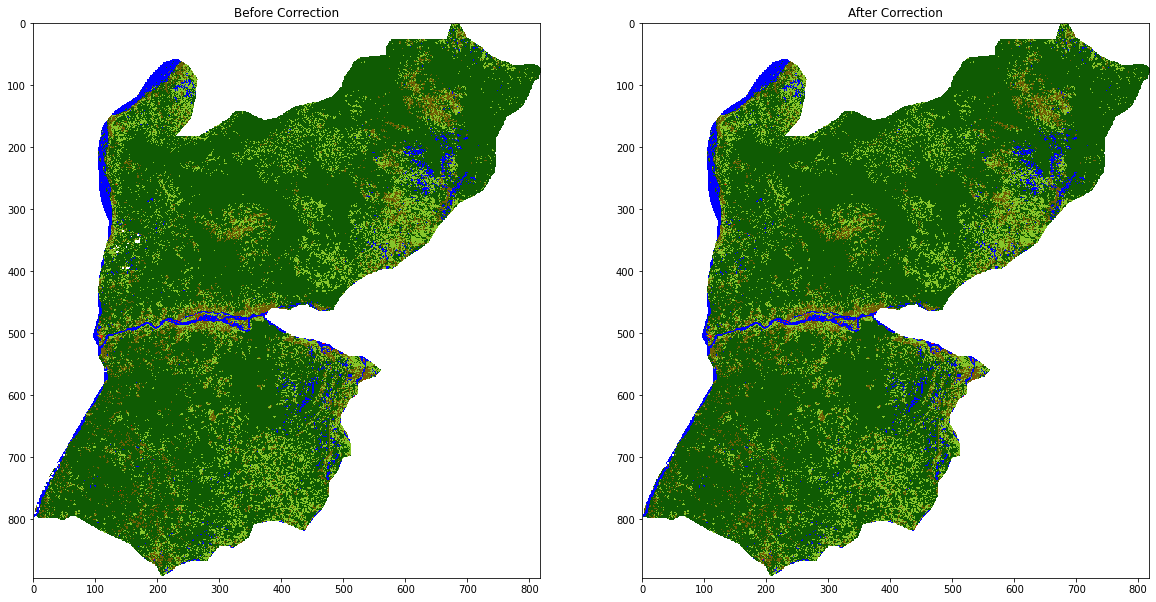

In [20]:
n = image_1.max()
# Next setup a colormap for our map
colors = dict((
    (1, (111, 97, 6,255)),  # Cropland (brown)
    (2, (135, 198, 42,255)),  # Shrubland (light green)
    (3, (15, 91, 3,255)),  # Forest (dark green)
    (4, (255, 26, 0,255)),  # Urban (red)
    (5, (0, 0, 255,255)),  # Water (blue)
    (6, (0, 0, 0,0)) #No Data/Clouds
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)


plt.figure(figsize = (20,25))

plt.subplot(121)
plt.title('Before Correction')
plt.imshow(image_2, cmap=cmap, interpolation='none')

#plt.figure(figsize = (8,8))
plt.subplot(122)
plt.title('After Correction')
plt.imshow(A, cmap=cmap, interpolation='none')


In [13]:

#plt.title('After Correction')
#plt.imshow(A, cmap=cmap, interpolation='none')

#save as numpy array, tif and png ahead of analysis
np.save('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2014_corrected_classified.npy', A)
plt.savefig( '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2014_corrected_classified.tif')
#plt.savefig( '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2019_corrected_classified.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
unique, counts = np.unique(image_2, return_counts=True)
list(zip(unique, counts))

In [ ]:
unique, counts = np.unique(A, return_counts=True)
list(zip(unique, counts))

## Calculating class cover time series

In [2]:
PIREDD_classified = '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified'

In [3]:
# Make a search criteria to select the files to loop over
search_criteria = "*.npy"
r = os.path.join(PIREDD_classified, search_criteria)
print(r)


# glob function can be used to list files from a directory with specific criteria
classified_images_piredd = glob.glob(r)

# Files that were found:
print(classified_images_piredd)

/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/*.npy
['/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2013_classified.npy', '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2014_corrected_classified.npy', '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2015_corrected_classified.npy', '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2016_corrected_classified.npy', '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2017_corrected_classified.npy', '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2018_corrected_classified.npy', '/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L

In [4]:

#lost for data frame
f = []
for classified in classified_images_piredd:
    p = np.load(classified)
    cropland = np.count_nonzero(p == 1)
    shrubland = np.count_nonzero(p == 2)
    forest = np.count_nonzero(p == 3)
    urban = np.count_nonzero(p == 4)
    water = np.count_nonzero(p == 5)
    f.append(
        {
            'Cropland  (sq m)': cropland*(30*30),
            'Savannah (sq m)': shrubland*(30*30),
            'Forest (sq m)': forest*(30*30),
            'Urban (sq m)' : urban*(30*30),
            'Water (sq m)' : water*(30*30)
        
        }
    )



df = pd.DataFrame(f, index = [2013, 2014,2015,2016,2017,2018,2019,2020])
df

,Cropland (sq m),Savannah (sq m),Forest (sq m),Urban (sq m),Water (sq m)
2013,15710400,41782500,246522600,203400,24825600
2014,21347100,50609700,241682400,86400,15437700
2015,22335300,43182900,252522900,152100,11001600
2016,9433800,29544300,274083300,103500,16030800
2017,18818100,44377200,252472500,145800,13405500
2018,13578300,34638300,272178900,104400,8719200
2019,21347100,50609700,241682400,86400,15437700
2020,14340600,37361700,250479000,90900,15966000


In [ ]:
#setting up years column
#r = np.array([2013, 2014,2015,2016,2017,2018,2019,2020])
#years = pd.Series(data=r).astype(int)
#idx=0
#df.insert(loc=idx, column='Years', value=years)

#df

In [7]:
#save as csv
df.to_csv('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Annual_Class_Areas.csv')


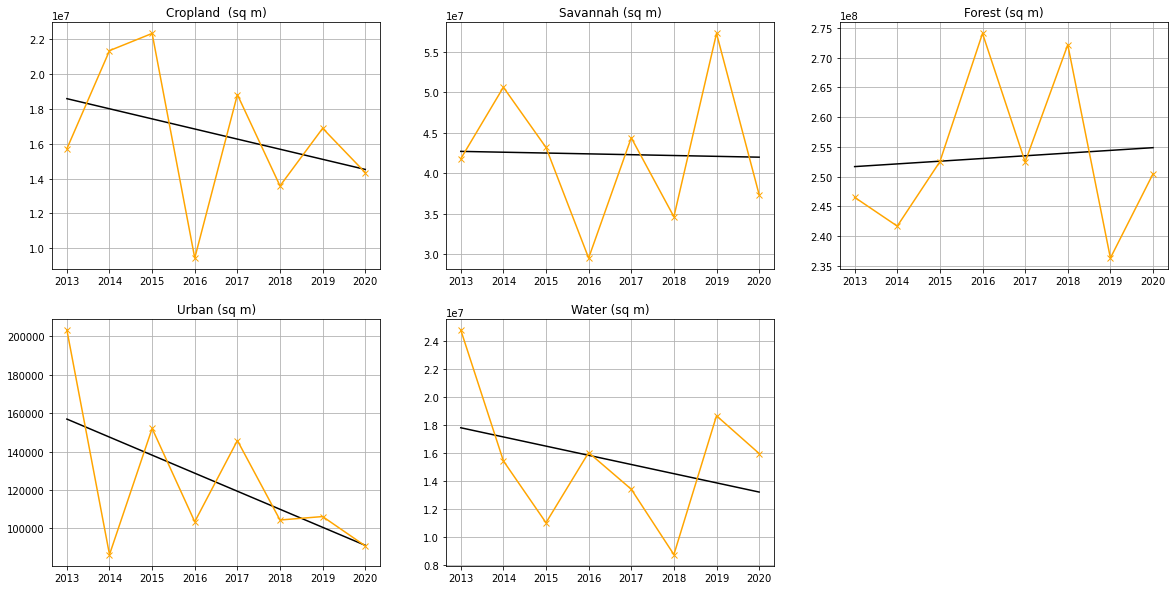

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

fig=plt.figure(figsize=(20,10))
columns = 3
rows = 2
for i in range(df.shape[1]):
    X = df.index.tolist()
    Y = df.iloc[:8,i]

    #plot data
    fig.add_subplot(rows, columns, i+1)
    #fig = sns.regplot(data = df, x = X, y = Y)
    slope, intercept, r, p, std_err = stats.linregress(X, Y)
    def myfunc(x):
        return slope * x + intercept
    mymodel = list(map(myfunc, X))

    plt.plot(X, mymodel, color = 'black')
    plt.plot(X, Y, marker = 'x', color = 'orange')### what you want you can plot
    plt.grid()
    plt.title(df.columns[i])
    

#plt.savefig('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Landcover_Time_Series.png')
plt.show()

In [ ]:
#plot only forest
#df_2.iloc[:8,2].plot(title='Time Series of all Landcover Class Areas', figsize=(10,10), xlabel='Year',ylabel='Area in Square Meters', grid=True, color = 'g')
#plt.savefig('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/PIREDD_Forest_Time_series.png')
#plt.show()


df.iloc[:8,2].plot.bar(title='Bar Graph of Forest Area', figsize=(10,10), xlabel='Year',ylabel='Area in Square Meters', grid=True, color = 'g')
#plt.savefig('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/PIREDD_Forest_Bar_Graph.png')
plt.show()


<AxesSubplot:title={'center':'Bar Graph of Annual Forest Cover'}, xlabel='Year', ylabel='Area in Square Meters'>

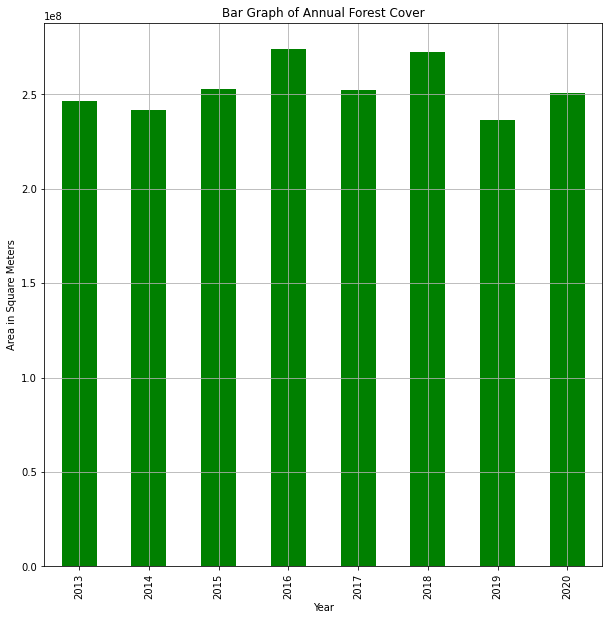

In [17]:
#plot annual forest cover
df['Forest (sq m)'].plot.bar(title='Bar Graph of Annual Forest Cover', figsize=(10,10), xlabel='Year',ylabel='Area in Square Meters', grid=True, color = 'g')

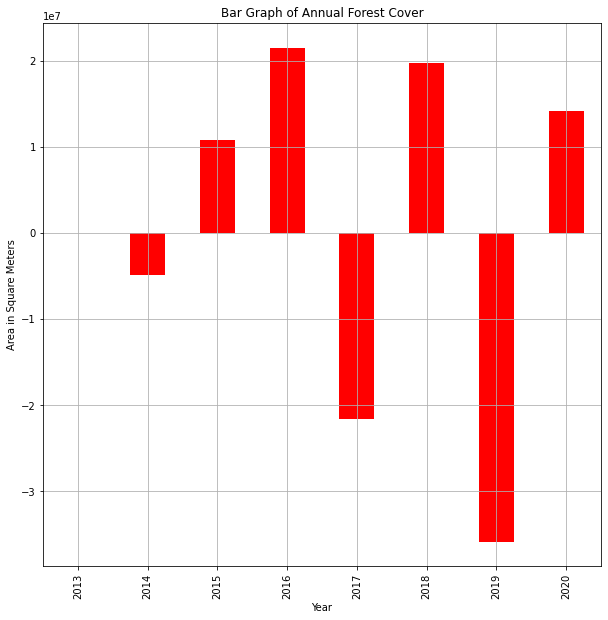

In [16]:
#plot annual forest loss
annual_forest_loss = df['Forest (sq m)'].diff()
annual_forest_loss.plot.bar(title='Bar Graph of Annual Forest Cover', figsize=(10,10), xlabel='Year',ylabel='Area in Square Meters', grid=True, color = 'r')
plt.show()

## Correcting for changeable pixels

In [5]:
#importing all landcover maps

lc_2013 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2013_classified.npy')
lc_2014 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2014_corrected_classified.npy')
lc_2015 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2015_corrected_classified.npy')
lc_2016 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2016_corrected_classified.npy')
lc_2017 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2017_corrected_classified.npy')
lc_2018 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2018_corrected_classified.npy')
lc_2019 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2019_corrected_classified.npy')
lc_2020 = np.load('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/PIREDD_Classified/Corrected_Classified/PIREDD_Plataue_L8_2020_classified.npy')

In [6]:
#2013-2014
change_1 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2013[i,j] != lc_2014[i,j]:
            change_1[i,j] = 1 #no change
        else:
            change_1[i,j] = 0 #blank out all other pixels/changes

In [7]:
#2014-2015
change_2 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2014[i,j] != lc_2015[i,j]:
            change_2[i,j] = 1 #no change
        else:
            change_2[i,j] = 0 #blank out all other pixels/changes

In [8]:
#2015-2016
change_3 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2015[i,j] != lc_2016[i,j]:
            change_3[i,j] = 1 #no change
        else:
            change_3[i,j] = 0 #blank out all other pixels/changes

In [9]:
#2015-2016
change_4 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2015[i,j] != lc_2016[i,j]:
            change_4[i,j] = 1 #no change
        else:
            change_4[i,j] = 0 #blank out all other pixels/changes

In [10]:
#2016-2017
change_5 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2016[i,j] != lc_2017[i,j]:
            change_5[i,j] = 1 #no change
        else:
            change_5[i,j] = 0 #blank out all other pixels/changes

In [11]:
#2017-2018
change_6 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2017[i,j] != lc_2018[i,j]:
            change_6[i,j] = 1 #no change
        else:
            change_6[i,j] = 0 #blank out all other pixels/changes

In [12]:
#2018-2019
change_7 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2018[i,j] != lc_2019[i,j]:
            change_7[i,j] = 1 #no change
        else:
            change_7[i,j] = 0 #blank out all other pixels/changes

In [13]:
#2019-2020
change_8 = np.ones(lc_2013.shape)
for i in range(lc_2013.shape[0]):
    for j in range(lc_2013.shape[1]):
        #forest, cloud, forest
        if lc_2019[i,j] != lc_2020[i,j]:
            change_8[i,j] = 1 #no change
        else:
            change_8[i,j] = 0 #blank out all other pixels/changes

In [14]:
change_1 = change_1.astype(int)
change_2 = change_2.astype(int)
change_3 = change_3.astype(int)
change_4 = change_4.astype(int)
change_5 = change_5.astype(int)
change_6 = change_6.astype(int)
change_7 = change_7.astype(int)
change_8 = change_8.astype(int)

In [15]:
change_counts = change_1 + change_2 + change_3 + change_4 + change_5 + change_6 + change_7 + change_8

In [16]:
change_counts.shape

(895, 818)

In [17]:
np.count_nonzero(change_counts < 1)

521912

In [18]:
np.count_nonzero(change_counts < 2)

555015

In [19]:
## setting the condition that valid pixels are those that change less than twice in the time period
valid_pixel = np.where(change_counts < 2,1,0) #1 is valid, 0 is invalid

In [22]:
valid_pixel.shape

(895, 818)

In [20]:
np.count_nonzero(valid_pixel == 1)

555015

In [21]:
np.save('/gws/nopw/j04/ai4er/users/jl2182/data/Figures/Landcover_Change_Maps/valid_pixels.npy', valid_pixel)